시퀀셜 vs functional
- 시퀀셜
    - 순차 : 하나의 입력, 하나의 출력
    - 직관적, 이전 레이어를 다음레이어에 직접적으로 연결

    - 장점 : 
        - 구현이 빠르고 간단, 이해 쉬움
        - 복잡한 아키텍쳐에 한계가 있다.
    - 예시 : 
        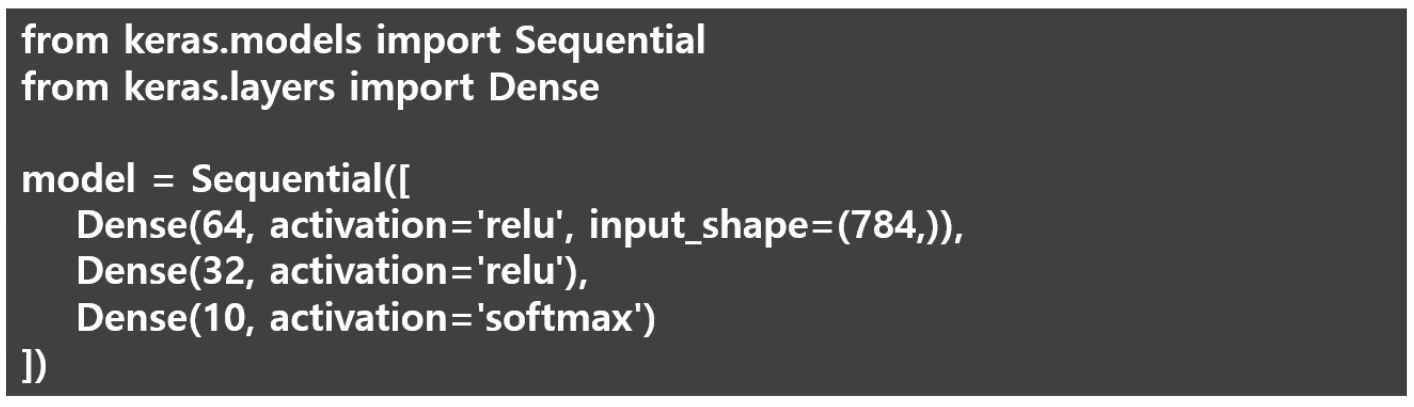
- fuctional
    - 레이어 공유, 병렬연결 등 복잡한 아키텍쳐
    - 매우 유연한 구조 설계 가능
    - 다중 입 출력, 레이어의 재사용, 레이어간의 복잡한 연결 가능
        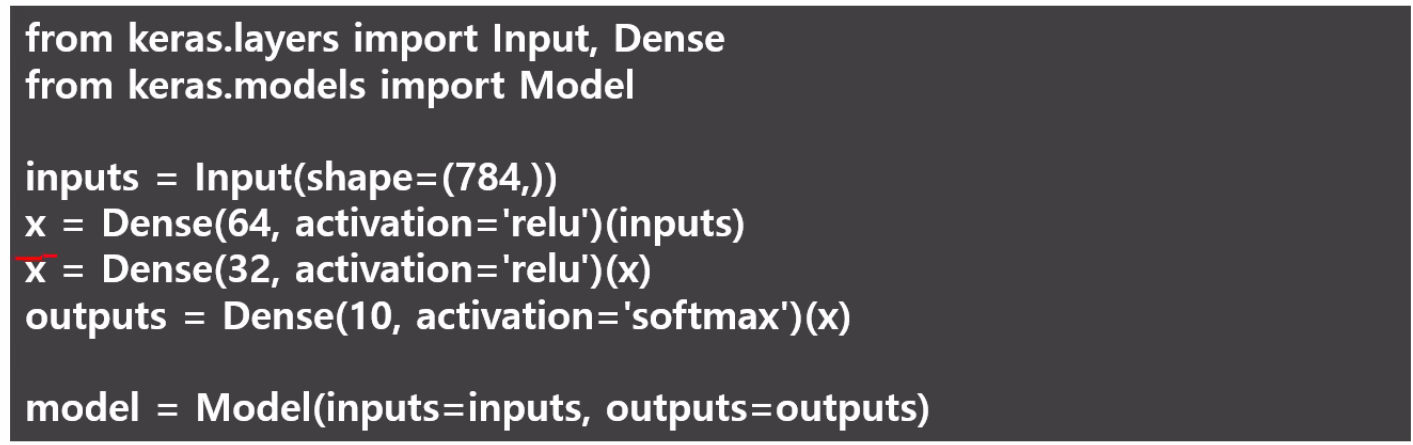
        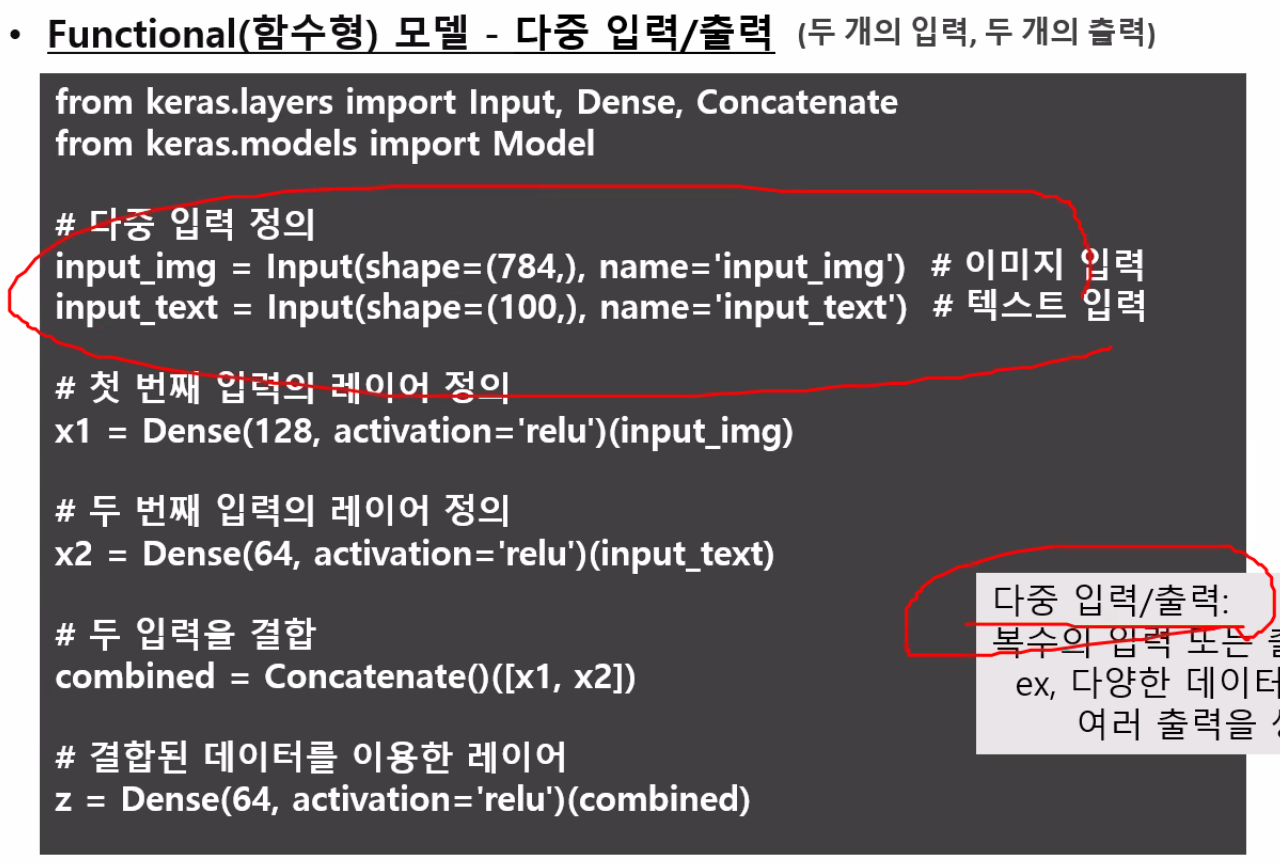
        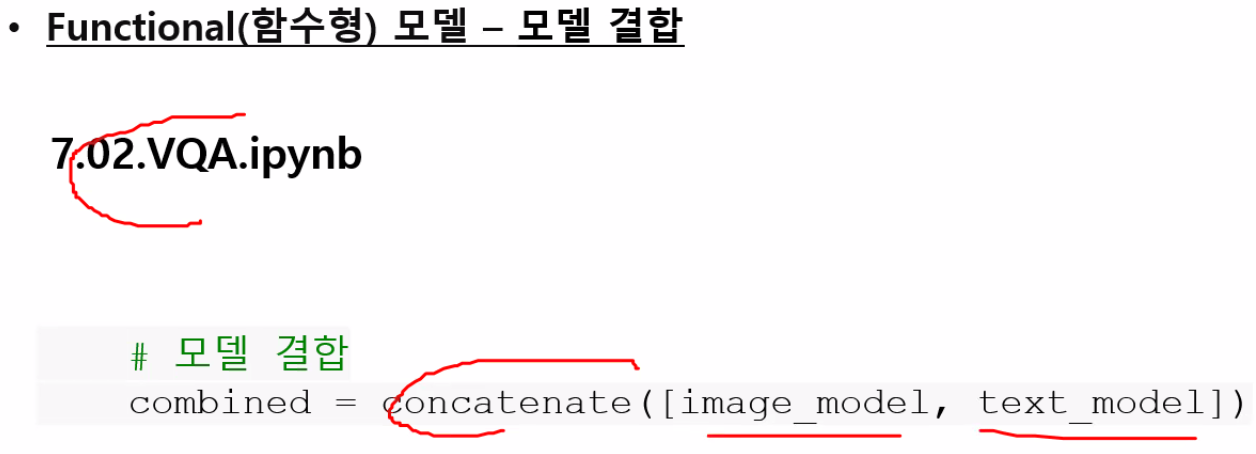
    


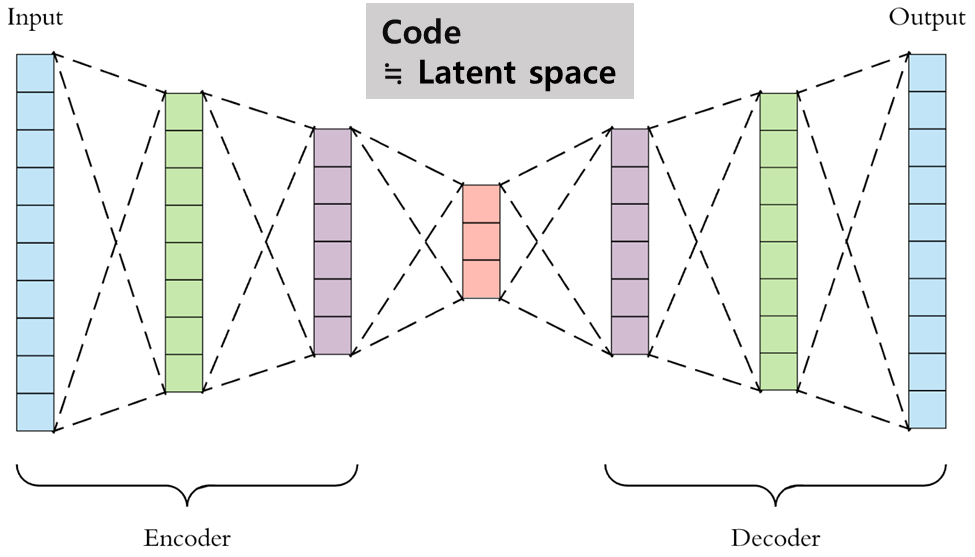

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Embedding, Flatten # Input 모델의 입력을 정의할 때 사용
                                           # 입력 데이터의 형태(shape)와 데이터 타입(dtype) 지정, InputLayer 객체 생성
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l1 # 정규화 과적합 방지
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Input scaling
x_train1 = x_train.astype('float32')/255
x_test1 = x_test.astype('float32')/255

x_train = x_train1.reshape((60000, 28*28))
x_test = x_test1.reshape((10000, 28*28))

In [3]:
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [4]:
######  Autoencoder 구축
# 각 레이어의 설계를 통해 데이터의 압축 및 재구성을 수행하는 구조로 세팅
input_size = 784  # <-- 28 * 28  입력 데이터의 특성 수
hidden_size = 128
code_size = 32    # <-- latent vector 차원

### encoder  입력 데이터를 저차원의 코드로 압축
input_img = Input(shape=(input_size,))  #Input: 모델 입력을 정의
hidden_1 = Dense(hidden_size, activation='relu')(input_img)  # 이전 레이어의 출력(input_img)을 입력으로 사용
code = Dense(code_size, activation='relu')(hidden_1)
 # code: 인코더의 마지막 레이어, code_size: 노드수 = 잠재 공간(latent space)의 차원 수

### decoder 원본 데이터와 같은 차원으로 복원
hidden_2 = Dense(hidden_size, activation='relu')(code)
  # 인코더의 출력인 code를 입력으로 받음
output_img = Dense(input_size, activation='sigmoid')(hidden_2)
  # 디코더의 마지막 층, 재구성된 이미지 출력
  # 출력 크기는의 원본 입력 이미지의 크기(input_size)와 동일
  # sigmoid 활성화 함수를 사용, 출력 값을 [0, 1] 범위로 제한 -> 이미지의 픽셀 값과 같은 형태로 데이터 복원에 적합.
  # 인풋의 각 픽셀과, 아웃풋의 각 픽셀을 비교하여 사용 그래서 시그모이드를 사용한다.
autoencoder = Model(input_img, output_img)
# AE 모델 정의, 인코더와 디코더를 하나의 모델로 결합
# input_img를 입력으로 받아 output_img를 출력


In [22]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dense_3 (Dense)             (None, 784)               101136    
                                                                 
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


In [5]:
autoencoder.compile(optimizer='adam', loss='mse')


In [6]:
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 9s 3ms/step - loss: 0.0242
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0117
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0099
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0091
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0086


In [7]:
# 모델 성능 평가
test_loss = autoencoder.evaluate(x_test, x_test)
print("Test loss:", test_loss)


313/313 [==============================] - 1s 2ms/step - loss: 0.0081
Test loss: 0.00808830838650465


Test loss: 0.009734303690493107 --> 0.008551281876862049 <br>
평균적으로 각 픽셀의 예측 오차가 작음<br>
0부터 1 사이의 값으로 정규화된 픽셀 값의 MSE 값이 0.0097(제곱근을 취하면 약 0.0985).<br>
평균적으로 각 픽셀 값이 실제 값과 약 0.1 정도 차이 발생.

In [8]:
test_mse = autoencoder.evaluate(x_test, x_test)
print("Test mse:", test_mse)


313/313 [==============================] - 1s 2ms/step - loss: 0.0081
Test mse: 0.00808830838650465


In [9]:
decoded_imgs = autoencoder.predict(x_test)

313/313 [==============================] - 1s 1ms/step


In [10]:
decoded_imgs = decoded_imgs.reshape((10000,28,28))

In [11]:
decoded_imgs.shape

(10000, 28, 28)

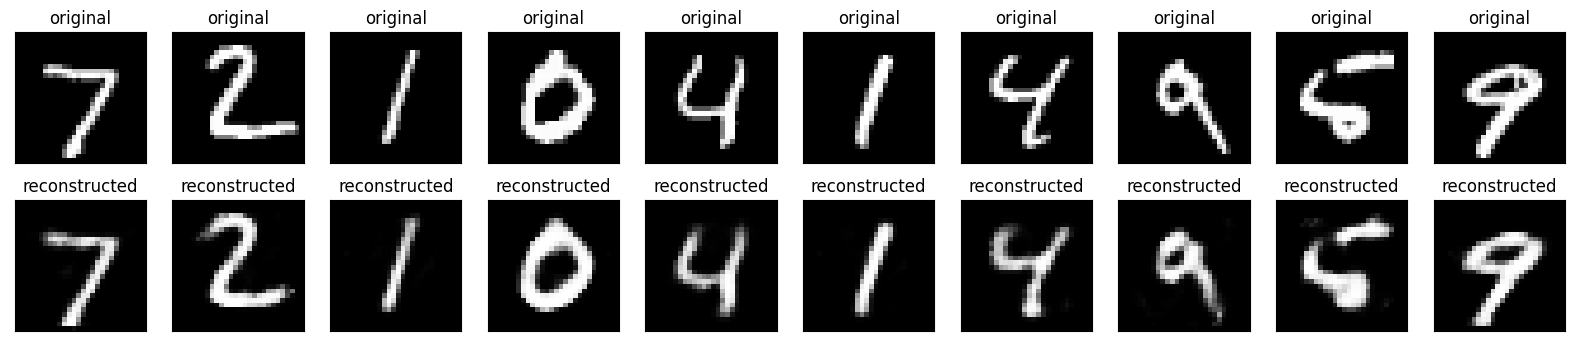

In [12]:
# 원본 이미지와 복원 이미지 비교
n=10 # 비교할 이미지의 수
plt.figure(figsize=(20,4))
for i in range(n):
    # 원본이미지
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test1[i]) # 원본이미지
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 복원 이미지
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i]) # 복원 이미지
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [13]:
#### 특징들이 잘 추출 되어 압축되었느가 확인
############# 저차원 벡터(representation vector)를 이용한 분류
encoder = Model(inputs=input_img, outputs=code) # encoder  부분만 사용

In [14]:
# encode 훈련셋
X_train_encode = encoder.predict(x_train)  # 32차원의 저차원 벡터 생성
# encode 검증셋
X_test_encode = encoder.predict(x_test)

313/313 [==============================] - 0s 1ms/step


In [15]:
X_train_encode.shape

(60000, 32)

In [16]:
#################### 분류 모델링
from tensorflow.keras import models
from tensorflow.keras import layers

In [17]:
model = models.Sequential()
model.add(layers.Dense(128, activation = 'relu', input_shape=(X_train_encode.shape[1],)))
model.add(layers.Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               4224      
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 5,514
Trainable params: 5,514
Non-trainable params: 0
_________________________________________________________________


In [18]:
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)


In [19]:
from tensorflow.keras import optimizers
rmsprop = optimizers.RMSprop(learning_rate=0.001)

In [20]:
model.compile(optimizer=rmsprop,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
history = model.fit(X_train_encode, y_train_one_hot, epochs=20, batch_size=128, validation_split = 0.2)

Epoch 1/20
375/375 [==============================] - 2s 4ms/step - loss: 0.6694 - accuracy: 0.7985 - val_loss: 0.3348 - val_accuracy: 0.9012
Epoch 2/20
375/375 [==============================] - 1s 4ms/step - loss: 0.3312 - accuracy: 0.8997 - val_loss: 0.3045 - val_accuracy: 0.9061
Epoch 3/20
375/375 [==============================] - 1s 4ms/step - loss: 0.2654 - accuracy: 0.9206 - val_loss: 0.2145 - val_accuracy: 0.9368
Epoch 4/20
375/375 [==============================] - 1s 4ms/step - loss: 0.2252 - accuracy: 0.9330 - val_loss: 0.1894 - val_accuracy: 0.9442
Epoch 5/20
375/375 [==============================] - 1s 4ms/step - loss: 0.1949 - accuracy: 0.9404 - val_loss: 0.1736 - val_accuracy: 0.9484
Epoch 6/20
375/375 [==============================] - 2s 4ms/step - loss: 0.1731 - accuracy: 0.9475 - val_loss: 0.1570 - val_accuracy: 0.9553
Epoch 7/20
375/375 [==============================] - 1s 4ms/step - loss: 0.1602 - accuracy: 0.9516 - val_loss: 0.1570 - val_accuracy: 0.9542
Epoch 